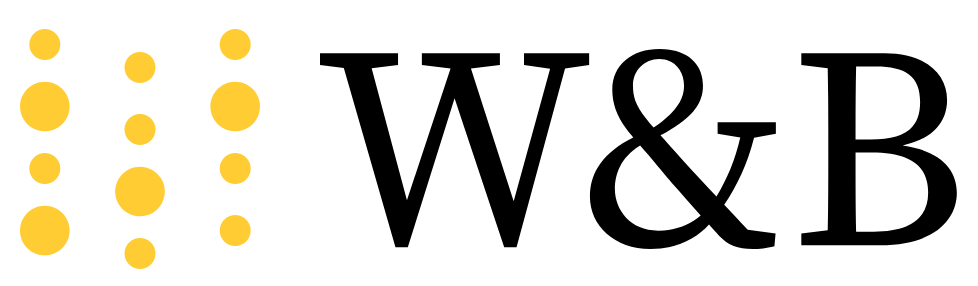

### What is W&B?
Short, W&B is a place where you can very easy and quickly log on experiments:

* your datasets
* your visualisations and findings
* your machine learning experiments (trying on multiple types of algorithms or hyperparameter tunning and logging the validation metric to see how they compare)
* your final models to use later

No more messy local folders with everything in 1 place. No more struggle to remember the best parameters for a model because you forgot to write them down. It's your perfect "Data Science Git".

In [ ]:
!pip install -qq albumentations==1.0.3
!pip install wandb --upgrade
!pip install timm
!pip install torch==1.10.0

### About this notebook?
* The code in this notebook is modularized using classes and functions.
* All the hyperparameters are well placed inside a single class, hence its easy to change them.
* Use of weights and biases will aloow you to monitor the performance of your model.
* Used swin transformer.
* Have used Focal loss which is an improved version of cross entropy loss.
* Reference materials

#### ***Do upvote this notebook if you have liked the content.***

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import functools
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
import timm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import AveragePrecision, Recall, F1
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import albumentations

from albumentations.pytorch.transforms import ToTensorV2

import wandb
wandb.login()

In [ ]:
data = pd.read_csv('../input/sorghum-id-fgvc-9/train_cultivar_mapping.csv')
sub_csv = pd.read_csv('../input/sorghum-id-fgvc-9/sample_submission.csv')
data.shape, sub_csv.shape

In [ ]:
len(list(data.cultivar.unique()))

### Class Imbalance

In [ ]:
class_counts = dict(data.cultivar.value_counts())
keys = list(class_counts.keys())
values = list(class_counts.values())
plt.figure(figsize=(10, 20))
sns.barplot(values, keys)

## Configurations

In [ ]:
#None will be filled later during the process.
class Config:
    #general.
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    proj_name = 'Sorghum Kaggle Competition'
    submission_file = 'submission.csv'
    
    #dataset params.
    train_folder = '../input/sorghum-id-fgvc-9/train_images'
    test_folder = '../input/sorghum-id-fgvc-9/test'
    sub_folder = '../input/sorghum-id-fgvc-9/test'
    val_percent = 0.2
    
    #model params.
    model_name = 'swin_base_patch4_window7_224'
    img_dim = 224
    out_features = len(list(data.cultivar.unique()))
    in_channels = 3
    pretrained = True
    dropout = 0.25
    
    #train params.
    epochs = 2
    batch_size = 16
    learning_rate = 2e-5
    penalty = 2 #loss.
    transform = None
    

## Dataset Class

In [ ]:
class sorghumDataset(Dataset):
    
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return (self.images[index], torch.tensor(self.labels[index]))
    
class sorghumTestDataset(Dataset):
    
    def __init__(self, images):
        self.images = images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index]

### Swin Transformer

The SwinT (Swin Transformer) is a type of Vision Transformer. SwinT is the first transformer-based backbone architecture for visual tasks. The contribution of the paper is that the authors are addressing a couple of problems that are faced while employing Transformers for visual tasks, like the large variations in the scale of objects in the image and also the pixel count in images compared to words in the text. Calculating self-attention with every other vector is computationally inefficient. Hence the authors have proposed a hierarchical transformer with a shifted window mechanism for calculating self-attention. The hierarchical structure will enhance the flexibility of the model. Shifted window mechanism will limit the computation of self-attention to local windows and also allow for cross-window connection.

## Model Class

In [ ]:
class sorghumModel(nn.Module):
    
    def __init__(self, model_name, out_features, in_channels=3, drop_prob=0.2, pretrained=True):
        super(sorghumModel, self).__init__()
        self.out_features = out_features
        self.in_channels = in_channels
        
        self.pre_model = timm.create_model(model_name, pretrained=pretrained, in_chans=in_channels)
        in_features = self.pre_model.head.in_features
        self.pre_model.head = nn.Linear(in_features, 1024, bias=True)
        
        self.cnn_head = nn.Sequential(
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(512, 64, bias=True),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(64, self.out_features, bias=True),
        )
        
        self.drop_layer = nn.Dropout(drop_prob)
        
    def forward(self, image):
        image_feats = self.pre_model(image)
        image_feats = self.drop_layer(image_feats)
        preds = self.cnn_head(image_feats)
        return preds

In [ ]:
def train_transform_object(DIM = 384):
    return albumentations.Compose(
        [
            albumentations.Resize(DIM,DIM),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1),
                contrast_limit=(-0.1, 0.1), p=0.5
            ),
            albumentations.Flip(p=0.5),
            albumentations.Rotate (limit=90, always_apply=False, p=0.5),
            albumentations.CenterCrop (height=Config.img_dim, width=Config.img_dim, always_apply=False, p=0.5),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0),
        ]
    )

def valid_transform_object(DIM = 384):
    return albumentations.Compose(
        [
            albumentations.Resize(DIM,DIM),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0)
        ]
    )

def collate_fn(batch, process):
    images, labels = [], []
    for sample in batch:
        im_name, im_label = sample[0], sample[1]
        im = cv2.imread(os.path.join(Config.train_folder, im_name), 1)
        if Config.transform is not None:
            if process == 'training':
                im = Config.transform['train_transform'](image=im)['image']
            else:
                im = Config.transform['valid_transform'](image=im)['image']
        images.append(im)
        labels.append(im_label)
    images_tensor = torch.stack(images)
    labels_tensor = torch.stack(labels)
    return images_tensor, labels_tensor

def collate_test_fn(batch):
    images = []
    for sample in batch:
        im_name = sample
        im = cv2.imread(os.path.join(Config.test_folder, im_name), 1)
        if Config.transform is not None:
            im = Config.transform['valid_transform'](image=im)['image']
        images.append(im)
    images_tensor = torch.stack(images)
    return images_tensor

### Focal Loss
> **Focal loss is an extension and improved version of cross entropy loss that focuses more on samples that are hard to classify than the ones that are easy to be classified. This reduces the overconfidence of the model. Just to note overfitting and overconfidence are two different terms.***

For more understanding on Focal Loss do have a read on [this](https://medium.com/visionwizard/understanding-focal-loss-a-quick-read-b914422913e7) Medium post. Its really good!!

The code for focal loss have been copied from [this](https://github.com/gokulprasadthekkel/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
) amazing github repository. Do check it out!!

In [ ]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=Config.penalty,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
def train_one_epoch(train_loader, model, epoch, criterion, optimizer):
    model.train()
    stream = tqdm(train_loader)
    total_loss = 0
    images_done = 0
    for i, (im_tensors, tar_tensors) in enumerate(stream, start=1):
        im_tensors = im_tensors.to(Config.device, non_blocking=True)
        tar_tensors = tar_tensors.float().view(-1, 1).squeeze(1).type(torch.LongTensor).to(Config.device, non_blocking=True)

        output = model(im_tensors)
        
        loss = criterion(output, tar_tensors)
        total_loss += float(loss)*len(im_tensors)
        images_done += len(im_tensors)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return total_loss/images_done
        
def validate(val_loader, model, epoch, criterion):
    model.eval()
    stream = tqdm(val_loader)
    final_targets = []
    final_outputs = []
    total_loss = 0
    images_done = 0
    with torch.no_grad():
        for i, (im_tensors, tar_tensors) in enumerate(stream, start=1):
            im_tensors = im_tensors.to(Config.device, non_blocking=True)
            tar_tensors = tar_tensors.float().view(-1, 1).squeeze(1).type(torch.LongTensor).to(Config.device, non_blocking=True)
    
            output = model(im_tensors)

            loss = criterion(output, tar_tensors)
            total_loss += float(loss)*len(im_tensors)
            images_done += len(im_tensors)
            
            target = (tar_tensors.detach().cpu().numpy()).tolist()
            output = (output.detach().cpu().numpy()).tolist()
            
            final_targets.extend(target)
            final_outputs.extend(output)

    return total_loss/images_done, torch.tensor(final_targets), torch.tensor(final_outputs)

def test(model, test_loader, id_class):
    sub_csv = pd.read_csv('../input/sorghum-id-fgvc-9/sample_submission.csv')
    sub_csv = sub_csv.loc[:100]
    
    model.eval()
    stream = tqdm(test_loader)
    final_outputs = []
    with torch.no_grad():
        for i, im_tensors in enumerate(stream, start=1):
            im_tensors = im_tensors.to(Config.device, non_blocking=True)
            output = model(im_tensors)            
            output = (output.detach().cpu().numpy()).tolist()
            final_outputs.extend(output)
    
    classes = cvt_classes(torch.tensor(final_outputs))
    sub_csv['cultivar'] = classes
    sub_csv['cultivar'] = sub_csv['cultivar'].map(id_class)
    return sub_csv

In [ ]:
def remove_missing_images(data):
    images = data['image'].values
    indices = []
    for i in range(data.shape[0]):
        im = data.image.iloc[i]
        if not os.path.exists(os.path.join(Config.train_folder, im)):
            indices.append(i)
    data = data.drop(indices, axis=0).reset_index(drop=True)
    return data

def setup_training(hyp):
    data = pd.read_csv('../input/sorghum-id-fgvc-9/train_cultivar_mapping.csv')
    data = data.loc[:1000]
    data = remove_missing_images(data)
    
    classes = list(data.cultivar.unique())
    id_class = dict([(k, v) for k, v in enumerate(classes)])
    class_id = dict([(v, k) for k, v in id_class.items()])
    data['cultivar'] = data['cultivar'].map(class_id)

    images, labels = data.image.values, data.cultivar.values
    train_data, val_data, train_labels, val_labels = train_test_split(images, 
                                                                      labels,
                                                                      test_size=Config.val_percent, 
                                                                      stratify=labels, 
                                                                      shuffle=True)
    
    train_dataset = sorghumDataset(train_data, train_labels)
    val_dataset = sorghumDataset(val_data, val_labels)
    
    train_collate = functools.partial(collate_fn, process='training')
    valid_collate = functools.partial(collate_fn, process='validation')
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=Config.batch_size, collate_fn=train_collate)
    val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=Config.batch_size, collate_fn=valid_collate)
    
    model = sorghumModel(model_name=hyp.model_name, 
                         out_features=hyp.out_features, 
                         in_channels=hyp.in_channels, 
                         drop_prob=hyp.drop_prob,
                         pretrained=hyp.pretrained)
    model.to(Config.device)
    loss_fn = FocalLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=hyp.lr_rate, weight_decay=1e-6, amsgrad=False)
    
    return id_class, model, train_dataloader, val_dataloader, loss_fn, optimizer

def setup_testing():
    test_data = pd.read_csv('../input/sorghum-id-fgvc-9/sample_submission.csv')
    test_data = test_data.loc[:100]
    test_images = test_data.filename.values
    test_dataset = sorghumTestDataset(test_images)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=Config.batch_size, collate_fn=collate_test_fn)
    return test_dataloader

In [ ]:
'''
Convert the output probablities of the model to the class
'''
def cvt_classes(outputs):
    outputs = torch.nn.functional.softmax(outputs)
    outputs = outputs.detach().cpu().numpy()
    outputs = outputs.argmax(axis=1)
    return torch.tensor(outputs).int()

def train(model, tr_loader, val_loader, criterion, optimizer, params):
    wandb.watch(model, criterion, log='all', log_freq=10)
    for epoch in range(params.epochs):
        train_loss = train_one_epoch(tr_loader, model, epoch, criterion, optimizer)
        val_loss, targets, predictions = validate(val_loader, model, epoch, criterion)
        outputs = cvt_classes(predictions)
        accuracy = accuracy_score(outputs, targets) 
        wandb.log({ 'epoch' : epoch, 'train_loss' : train_loss, 'val_loss' : val_loss, 'accuracy' : accuracy }, step=epoch)
        torch.save(model.state_dict(), '{}_epoch{}.pth'.format(params.model_name, epoch))

def model_pipeline(train_parameters):
    with wandb.init(project=Config.proj_name, config=train_parameters):
        parameters = wandb.config
        id_class, model, train_loader, val_loader, criterion, optimizer = setup_training(parameters)
        train(model, train_loader, val_loader, criterion, optimizer, parameters)
        test_loader = setup_testing()
        result = test(model, test_loader, id_class)
        result.to_csv(Config.submission_file, index=False)

**As you finish training you will have a submission.csv and the model saved to the output directory**

## Train and test the model

In [ ]:
train_params = {
    'model_name' : Config.model_name,
    'out_features' : Config.out_features,
    'in_channels' : Config.in_channels,
    'drop_prob' : Config.dropout,
    'pretrained' : Config.pretrained,
    'epochs' : Config.epochs,
    'lr_rate' : Config.learning_rate,
}

Config.transform = {
    'train_transform' : train_transform_object(Config.img_dim),
    'valid_transform' : valid_transform_object(Config.img_dim)
}

model_pipeline(train_params)